In [1]:
import os
import sys
import math
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet
from sklearn.decomposition import NMF
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../../')
import ccal
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

==================== Computational Cancer Analysis Library ====================
<17:38:39.195347> Checking dependencies ...
<17:38:39.197624> Using the following packages:
<17:38:39.199390> 	matplotlib (v1.5.1)
<17:38:39.199407> 	numpy (v1.10.4)
<17:38:39.199417> 	pandas (v0.18.0)
<17:38:39.199438> 	rpy2 (v2.7.9)
<17:38:39.199447> 	scikit-learn (v0.17.1)
<17:38:39.199454> 	scipy (v0.17.0)
<17:38:39.199461> 	seaborn (v0.7.0)


In [2]:
features = ccal.support.make_random_features(1, 1000)
ref = ccal.support.make_random_features(1, 1000)
features, ref, annotations = ccal.analyze.rank_features_against_reference(features, ref, n_sampling=2,
                                             n_perm=2, n_features=0, title='Continuous {} x {}'.format(1, 10),
                                            output_prefix='/Users/Kwat/Desktop/test', figure_type='.pdf')

<17:38:39.708837> Computing features vs. Feature 0 using information_coef metric ...
<17:38:39.709294> Using 1000 intersecting columns from features and ref, which have 1000 and 1000 columns respectively ...
<17:38:39.712364> Computing scores using information_coef metric ...
<17:38:39.771417> Bootstrapping to get 0.95 confidence interval ...
<17:38:39.867032> Performing permutation test with 2 permutations ...
<17:38:40.002920> Saved the result as /Users/Kwat/Desktop/test.txt.
<17:38:40.006319> Plotting 1 features vs. reference > 0 quantile ...
<17:38:40.007289> Plotting 1 features vs. reference < 1 quantile ...


In [3]:
def setup_heatmap_parameters(data_type):
    if data_type is 'continuous':
        data_cmap = CMAP_CONTINUOUS
        data_min, data_max = -3, 3
    elif data_type is 'categorical':
        data_cmap = CMAP_CATEGORICAL
        data_min, data_max = 0, np.unique(features.values).size
    elif data_type is 'binary':
        data_cmap = CMAP_BINARY
        data_min, data_max = 0, 1
    else:
        raise ValueError('Unknown data_type {}.'.format(data_type))
    return data_cmap, data_min, data_max


def normalize_pandas_object(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        for i, (idx, s) in enumerate(pandas_obj.iterrows()):
            mean = s.mean()
            std = s.std()
            for j, v in enumerate(s):
                pandas_obj.ix[i, j] = (v - mean) / std
    elif isinstance(pandas_obj, pd.Series):
        pandas_obj = (pandas_obj - ref.mean()) / pandas_obj.std()

In [4]:
from ccal.visualize import *
features_type = 'continuous'
ref_type = 'continuous'
_print = print
title = 'Title'
plot_colname = True
figure_type = '.png'
title_size = 16
annotation_label_size = 9

# Option 1

Normalizing continuous features ...
Normalizing continuous ref ...


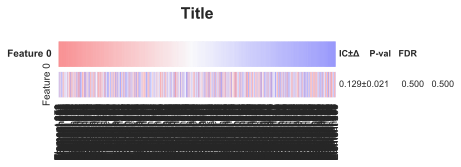

Saved the figure as /Users/Kwat/Desktop/option1.png.


In [5]:
filename_prefix = '/Users/Kwat/Desktop/option1'


features_cmap, features_min, features_max = setup_heatmap_parameters(features_type)
ref_cmap, ref_min, ref_max = setup_heatmap_parameters(ref_type)

# Normalize
if features_type is 'continuous':
    _print('Normalizing continuous features ...')
    normalize_pandas_object(features)
if ref_type is 'continuous':
    _print('Normalizing continuous ref ...')
    ref = (ref - ref.mean()) / ref.std()
    normalize_pandas_object(ref)
    
fig = plt.figure(figsize=(min(math.pow(features.shape[1], 0.5), 7), math.pow(features.shape[0], 0.9)))
horizontal_text_margin = math.pow(features.shape[1], 0.39)
gridspec=plt.GridSpec(features.shape[0] + 1, features.shape[1] + 1)

# Plot ref, ref label, and title, 
ref_ax = plt.subplot(gridspec.new_subplotspec((0, 0), colspan=features.shape[1]))
sns.heatmap(pd.DataFrame(ref).T, vmin=ref_min, vmax=ref_max, cmap=ref_cmap, xticklabels=False, cbar=False)
plt.setp(ref_ax.get_yticklabels(), rotation=0)
plt.setp(ref_ax.get_yticklabels(), weight='bold')

if title:
    ref_ax.text(features.shape[1] / 2, 1.9, title, horizontalalignment='center', size=title_size, weight='bold')

if ref_type in ('binary', 'categorical'):
    # Add binary or categorical ref labels
    boundaries = [0]
    prev_v = ref.iloc[0]
    for i, v in enumerate(ref.iloc[1:]):
        if prev_v != v:
            boundaries.append(i + 1)
        prev_v = v
    boundaries.append(features.shape[1])
    label_horizontal_positions = []
    prev_b = 0
    for b in boundaries[1:]:
        label_horizontal_positions.append(b - (b - prev_b) / 2)
        prev_b = b
    # TODO: implement get_unique_in_order
    unique_ref_labels = np.unique(ref.values)[::-1]
    for i, pos in enumerate(label_horizontal_positions):
        ref_ax.text(pos, 1, unique_ref_labels[i], horizontalalignment='center', weight='bold')

# Plot features
features_ax = plt.subplot(gridspec.new_subplotspec((1, 0), rowspan=features.shape[0], colspan=features.shape[1]))
sns.heatmap(features, vmin=features_min, vmax=features_max, cmap=features_cmap, xticklabels=plot_colname, cbar=False)
plt.setp(features_ax.get_yticklabels(), rotation=0)

# Plot annotations
annotation_header_ax = plt.subplot(gridspec.new_subplotspec((0, features.shape[1])))
annotation_header_ax.set_axis_off()
a = '\t'.join(annotations.columns).expandtabs()
annotation_header_ax.text(horizontal_text_margin, 0.5, a, horizontalalignment='left', verticalalignment='center', size=annotation_label_size, weight='bold')
for i, (idx, s) in enumerate(annotations.iterrows()):
    ax = plt.subplot(gridspec.new_subplotspec((1 + i, features.shape[1])))
    ax.set_axis_off()
    a = '\t'.join(s.tolist()).expandtabs()
    ax.text(horizontal_text_margin, 0.5, a, horizontalalignment='left', verticalalignment='center', size=annotation_label_size)

fig.subplots_adjust(left=0.15, right=0.7)
plt.show(fig)

if filename_prefix:
    filename = filename_prefix + figure_type
    fig.savefig(filename, dpi=900)
    _print('Saved the figure as {}.'.format(filename))

# Option 2

Normalizing continuous features ...
Normalizing continuous ref ...


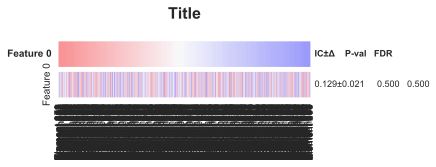

Saved the figure as /Users/Kwat/Desktop/option2.png.


In [6]:
filename_prefix = '/Users/Kwat/Desktop/option2'

features_cmap, features_min, features_max = setup_heatmap_parameters(features_type)
ref_cmap, ref_min, ref_max = setup_heatmap_parameters(ref_type)

# Normalize
if features_type is 'continuous':
    _print('Normalizing continuous features ...')
    normalize_pandas_object(features)
if ref_type is 'continuous':
    _print('Normalizing continuous ref ...')
    ref = (ref - ref.mean()) / ref.std()
    normalize_pandas_object(ref)
    
fig = plt.figure(figsize=(min(math.pow(features.shape[1], 0.5), 7), math.pow(features.shape[0], 0.9)))

heatmap_ncol = 10
gridspec=plt.GridSpec(features.shape[0] + 1, heatmap_ncol + 1)

# Plot ref, ref label, and title, 
ref_ax = plt.subplot(gridspec.new_subplotspec((0, 0), colspan=heatmap_ncol))
sns.heatmap(pd.DataFrame(ref).T, vmin=ref_min, vmax=ref_max, cmap=ref_cmap, xticklabels=False, cbar=False)
plt.setp(ref_ax.get_yticklabels(), rotation=0)
plt.setp(ref_ax.get_yticklabels(), weight='bold')

if title:
    ref_ax.text(features.shape[1] / 2, 1.9, title, horizontalalignment='center', size=title_size, weight='bold')

if ref_type in ('binary', 'categorical'):
    # Add binary or categorical ref labels
    boundaries = [0]
    prev_v = ref.iloc[0]
    for i, v in enumerate(ref.iloc[1:]):
        if prev_v != v:
            boundaries.append(i + 1)
        prev_v = v
    boundaries.append(features.shape[1])
    label_horizontal_positions = []
    prev_b = 0
    for b in boundaries[1:]:
        label_horizontal_positions.append(b - (b - prev_b) / 2)
        prev_b = b
    # TODO: implement get_unique_in_order
    unique_ref_labels = np.unique(ref.values)[::-1]
    for i, pos in enumerate(label_horizontal_positions):
        ref_ax.text(pos, 1.19, unique_ref_labels[i], horizontalalignment='center', weight='bold')

# Plot features
features_ax = plt.subplot(gridspec.new_subplotspec((1, 0), rowspan=features.shape[0], colspan=heatmap_ncol))
sns.heatmap(features, vmin=features_min, vmax=features_max, cmap=features_cmap, xticklabels=plot_colname, cbar=False)
plt.setp(features_ax.get_yticklabels(), rotation=0)

# Plot annotations
annotation_header_ax = plt.subplot(gridspec.new_subplotspec((0, heatmap_ncol)))
annotation_header_ax.set_axis_off()
a = '\t'.join(annotations.columns).expandtabs()
annotation_header_ax.text(0, 0.5, a, horizontalalignment='left', verticalalignment='center', size=annotation_label_size, weight='bold')
for i, (idx, s) in enumerate(annotations.iterrows()):
    ax = plt.subplot(gridspec.new_subplotspec((1 + i, heatmap_ncol)))
    ax.set_axis_off()
    a = '\t'.join(s.tolist()).expandtabs()
    ax.text(0, 0.5, a, horizontalalignment='left', verticalalignment='center', size=annotation_label_size)

fig.subplots_adjust(left=0.15, right=0.7)
plt.show(fig)

if filename_prefix:
    filename = filename_prefix + figure_type
    fig.savefig(filename, dpi=900)
    _print('Saved the figure as {}.'.format(filename))

# Option 3

Normalizing continuous features ...
Normalizing continuous ref ...
200
0
200
400
0
200
400


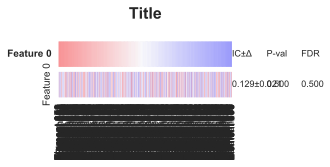

Saved the figure as /Users/Kwat/Desktop/option3.png.


In [ ]:
filename_prefix = '/Users/Kwat/Desktop/option3'

features_cmap, features_min, features_max = setup_heatmap_parameters(features_type)
ref_cmap, ref_min, ref_max = setup_heatmap_parameters(ref_type)

# Normalize
if features_type is 'continuous':
    _print('Normalizing continuous features ...')
    normalize_pandas_object(features)
if ref_type is 'continuous':
    _print('Normalizing continuous ref ...')
    ref = (ref - ref.mean()) / ref.std()
    normalize_pandas_object(ref)
    
fig = plt.figure(figsize=(min(math.pow(features.shape[1], 0.5), 7), math.pow(features.shape[0], 0.9)))
horizontal_text_margin = 200#int(math.pow(features.shape[1], 0.5))
gridspec=plt.GridSpec(features.shape[0] + 1, features.shape[1] + annotations.shape[1] * horizontal_text_margin)

# Plot ref, ref label, and title, 
ref_ax = plt.subplot(gridspec.new_subplotspec((0, 0), colspan=features.shape[1]))
sns.heatmap(pd.DataFrame(ref).T, vmin=ref_min, vmax=ref_max, cmap=ref_cmap, xticklabels=False, cbar=False)
plt.setp(ref_ax.get_yticklabels(), rotation=0)
plt.setp(ref_ax.get_yticklabels(), weight='bold')

if title:
    ref_ax.text(features.shape[1] / 2, 1.9, title, horizontalalignment='center', size=title_size, weight='bold')

if ref_type in ('binary', 'categorical'):
    # Add binary or categorical ref labels
    boundaries = [0]
    prev_v = ref.iloc[0]
    for i, v in enumerate(ref.iloc[1:]):
        if prev_v != v:
            boundaries.append(i + 1)
        prev_v = v
    boundaries.append(features.shape[1])
    label_horizontal_positions = []
    prev_b = 0
    for b in boundaries[1:]:
        label_horizontal_positions.append(b - (b - prev_b) / 2)
        prev_b = b
    # TODO: implement get_unique_in_order
    unique_ref_labels = np.unique(ref.values)[::-1]
    for i, pos in enumerate(label_horizontal_positions):
        ref_ax.text(pos, 1.19, unique_ref_labels[i], horizontalalignment='center', weight='bold')

# Plot features
features_ax = plt.subplot(gridspec.new_subplotspec((1, 0), rowspan=features.shape[0], colspan=features.shape[1]))
sns.heatmap(features, vmin=features_min, vmax=features_max, cmap=features_cmap, xticklabels=plot_colname, cbar=False)
plt.setp(features_ax.get_yticklabels(), rotation=0)

# Plot annotations
for i, a in enumerate(annotations.columns):
    print(i * horizontal_text_margin)
    ax = plt.subplot(gridspec.new_subplotspec((0, features.shape[1] + i * horizontal_text_margin)))
    ax.set_axis_off()
    ax.text(0, 0.5, a, horizontalalignment='left', verticalalignment='center', size=annotation_label_size)

for i, (idx, s) in enumerate(annotations.iterrows()):
    for j, a in enumerate(s):
        ax = plt.subplot(gridspec.new_subplotspec((1 + i, features.shape[1] + j * horizontal_text_margin)))
        ax.set_axis_off()
        ax.text(0, 0.5, a, horizontalalignment='left', verticalalignment='center', size=annotation_label_size)

fig.subplots_adjust(left=0.15, right=0.7)
plt.show(fig)

if filename_prefix:
    filename = filename_prefix + figure_type
    fig.savefig(filename, dpi=900)
    _print('Saved the figure as {}.'.format(filename))

In [ ]:
ccal.support.VERBOSE = False
for r in range(1, 500, 100):
    for c in range(1, 500, 100):
        features = ccal.support.make_random_features(r, c)
        ref = ccal.support.make_random_features(1, c)
        ccal.analyze.rank_features_against_reference(features, ref, n_sampling=2,
                                                     n_perm=2, n_features=0, title='Continuous {} x {}'.format(r, c))
        
n_category = 10
for r in range(1, 500, 100):
    for c in range(1, 500, 100):
        features = ccal.support.make_random_features(r, c, n_category=n_category)
        ref = ccal.support.make_random_features(1, c, n_category=n_category)
        ccal.analyze.rank_features_against_reference(features, ref, ref_type='categorical',
                                                     n_sampling=2, n_perm=2, n_features=0, title='Categorical {} x {}'.format(r, c))

n_category = 2
for r in range(1, 500, 100):
    for c in range(1, 500, 100):
        features = ccal.support.make_random_features(r, c, n_category=n_category)
        ref = ccal.support.make_random_features(1, c, n_category=n_category)
        ccal.analyze.rank_features_against_reference(features, ref, ref_type='binary',
                                                     n_sampling=2, n_perm=2, n_features=0, title='Binary {} x {}'.format(r, c))

# Test IC

In [ ]:
x = np.random.random_sample(10)
y = np.random.random_sample(10)
print(ccal.information.information_coefficient(x, y))

x = np.random.random_sample(10)
y = np.random.random_sample(11)
try:
    ccal.information.information_coefficient(x, y)
except ValueError as e:
    print(e)

x = np.random.random_sample(10)
x[1] = None
y = np.random.random_sample(10)
y[2] = None
print(ccal.information.information_coefficient(x, y))

x = np.random.random_sample(10)
x[1] = None
y = np.random.random_sample(10)
y[2] = None
y[6] = None
print(ccal.information.information_coefficient(x, y))

x = np.random.random_sample(10)
x[1] = None
x[3] = None
x[5] = None
y = np.random.random_sample(10)
y[2] = None
y[4] = None
print(ccal.information.information_coefficient(x, y))

x = np.array([12.517, 14.706, np.nan, 14.12, np.nan, np.nan, np.nan, 12.255])
y = np.array([0.98246356, 0.97525171, 0.77744759, 0.64084311, 0.4405853, 0.43827196, 0.12447757, 0.08116039])
print(ccal.information.information_coefficient(x, y))

# Make simulation matrix

In [ ]:
def add_value(df, inVal, outVal):
    # Add value in cluster
    # Set inVal or outVal to be None when not updating it
    
    for i,(n,s) in enumerate(df.iterrows()):
        #print('add_value:',i)
        for j,c in enumerate(s.index):
            if inVal and n==c:
                df.iloc[i,j]=inVal
            if outVal and n!=c:
                df.iloc[i,j]=outVal

def add_noise(df,inMu,inSigma,outMu,outSigma):
    # Add noise
    
    for i,(n,s) in enumerate(df.iterrows()):
        #print('add_noise:',i)
        for j,c in enumerate(s.index):
            if (inMu or inSigma) and n==c:
                df.iloc[i,j]+=random.gauss(inMu,inSigma)
            if (outMu or outSigma) and n!=c:
                df.iloc[i,j]+=random.gauss(outMu,outSigma)

def mix(df,k,mix):
    # Mix cluster values to nonclusters and vice versa
    
    assert k!=0, print('k cannot be 0')
    
    # Get the number of values in a cluster
    n_k_val=len(df.columns)*len(df.index)/k
    #print('n_k_val:',n_k_val)
    
    # Count
    c=0
    while c<mix*n_k_val:
        
        # Pick 1st random index and column
        r_idx0=random.randint(0,len(df.index)-1)
        r_col0=random.randint(0,len(df.columns)-1)

        # If index and column locate inside a cluster
        if df.index[r_idx0]==df.columns[r_col0]:    
            
            # Get cluster value located
            pick0=df.iloc[r_idx0,r_col0]
            
            # Pick 2nd random index and column
            r_idx1=random.randint(0,len(df.index)-1)
            r_col1=random.randint(0,len(df.columns)-1)
            
            # If index and column locate outside a cluster
            if df.index[r_idx1]!=df.columns[r_col1]:    

                # Get non-cluster value located
                pick1=df.iloc[r_idx1,r_col1]

                # Swap
                df.iloc[r_idx0,r_col0]=pick1
                df.iloc[r_idx1,r_col1]=pick0
                
                # Count
                c+=1
                
                #print('Swapped (%s,%s) & (%s,%s)'%(df.index[r_idx0],df.columns[r_col0],df.index[r_idx1],df.columns[r_col1]))

def initialize_simulation_df(df,inVal,inMu,inSigma,outVal,outMu,outSigma,mix):
    # Initialize values in and out of a cluster and add noise
    
    t0=time()
    
    # For each row
    for i,(n,s) in enumerate(df.iterrows()):
        print('initialize_simulation_df:',i)
        
        # For each column
        for j,c in enumerate(s.index):
            r=random.random()
            
            if mix and r<=mix:
                # Mix
                if n==c:
                    # In cluster gets out-value
                    df.iloc[i,j]=outVal
                    if outMu or outSigma:
                        df.iloc[i,j]+=random.gauss(outMu,outSigma)
                else:
                    # Out cluster gets in-value
                    df.iloc[i,j]=inVal
                    if inMu or inSigma:
                        df.iloc[i,j]+=random.gauss(inMu,inSigma) 
            else:
                # No mix
                if n==c:
                    # In cluster gets in-value
                    df.iloc[i,j]=inVal
                    if inMu or inSigma:
                        df.iloc[i,j]+=random.gauss(inMu,inSigma)
                else:
                    # Out cluster gets out-value
                    df.iloc[i,j]=outVal
                    if outMu or outSigma:
                        df.iloc[i,j]+=random.gauss(outMu,outSigma)
    print('initialize_simulation_df: done in %0.3fs.'%(time()-t0))

def plot_mtrx(mtrx):
    # Plot simulation matrix
    
    plt.imshow(mtrx,interpolation='nearest',cmap=plt.cm.ocean)
    plt.colorbar()
    plt.show()
    
def make_mtrx_sample_x_variable_simulation(n_sample,
                                           n_var,
                                           k,
                                           val_in,
                                           val_out,
                                           noise_in_mu=None,
                                           noise_in_sigma=None,
                                           noise_out_mu=None,
                                           noise_out_sigma=None,
                                           noise_mix=None,
                                           prefix_out_f=None,
                                           suffix_out_f=None,
                                           plot=False):
    """
    Make sample x variable matrix
    """
    assert k != 0, 'k cannot be 0'
    assert k <= n_var,'k cannot be greater than n_var'
    
    # Make an empty sample x variable matrix filled with 0
    mtrx_sample_x_var = pd.DataFrame(index=range(n_sample), columns=range(n_var)).fillna(0)

    # Slice dataframe index and column and make lists of dataframe indexes and columns for each index and column slice
    list_index_slice = toolK.slice_list(mtrx_sample_x_var.index, k)
    list_column_slice = toolK.slice_list(mtrx_sample_x_var.columns, k)

    # Make index and column slice x dataframe indexes dictionaries
    dict_index_slice = {}
    for i, l in enumerate(list_index_slice):
        dict_index_slice[i] = l
    dict_column_slice = {}
    for i, l in enumerate(list_column_slice):
        dict_column_slice[i] = l

    # Set dataframe index and column to be index and column slice indices respectively
    index=list(mtrx_sample_x_var.index)
    for i,l in dict_index_slice.items():
        for j in l:
            index[j]=i
    mtrx_sample_x_var.index=index
    columns=list(mtrx_sample_x_var.columns)
    for i,l in dict_column_slice.items():
        for j in l:
            columns[j]=i
    mtrx_sample_x_var.columns=columns

    # Initialize simulation matrix
    initialize_simulation_df(mtrx_sample_x_var,val_in,noise_in_mu,noise_in_sigma,val_out,noise_out_mu,noise_out_sigma,noise_mix)
    
    # Save
    if prefix_out_f:        
        mtrx_sample_x_var.to_csv(prefix_out_f+'_sample_%s_var_%s_k_%s_mix_%s_%s'%(n_sample,n_var,k,noise_mix,suffix_out_f),sep='\t')
    
    # Plot
    if plot:
        plot_mtrx(mtrx_sample_x_var)

# Make simulation matrix

# Set number of samples
list_n_sample = [100, 500, 1000, 5000]
# Set number of variables
list_n_var = [100, 500, 1000, 5000]
# Set values in clusters
val_in = 1
# Set values out of clusters
val_out = 0
# Set Ks
list_k = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25]
# Set the fractions of cluster values to be swapped between clusters and nonclusters
list_noise_mix = [0, 0.05, 0.1, 0.2]
# Set noise in clusters
noise_in_mu = 0
noise_in_sigma = 0.1 * noise_in_mu
# Set noise out of clusters
noise_out_mu = 0
noise_out_sigma = 0.1*noise_out_mu

# Simulate
for sample in list_n_sample:
    print('sample:',sample)
    
    for var in list_n_var:
        print('\tvar:',var)
        
        for k in list_k:
            print('\t\tk:',k)
            
            for noise_mix in list_noise_mix:
                print('\t\t\tnoise_mix:',noise_mix)
                
                make_mtrx_sample_x_variable_simulation(sample,
                                                       var,
                                                       k,
                                                       val_in,
                                                       val_out,
                                                       noise_mix=noise_mix,
                                                       prefix_out_f='/cellar/users/hyeerna/aLL/mtrx_sample_x_var_simulation/test/',
                                                       suffix_out_f='sfx',
                                                       plot=True)